In [1]:
# Importing all the required libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim
from torchvision import transforms
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

import random
random.seed(123)


import cv2
from torch.autograd import Variable

from PIL import Image
import pandas as pd
import os
import glob
import pickle
import csv

from sklearn.metrics import accuracy_score

import time
cmap = plt.cm.jet

## Preprocessing Images to same dimensions

In [2]:
def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad


def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    """ Pre-processing image for predicting """
    img = cv2.imread(path)
    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img = img.astype(np.float32)
    img /= 255
    return img

### Required Paths

In [3]:
# Getting current working directory to get back to this directory easily
cwd=os.getcwd()
images_path='C:\\Users\\jimev\\Desktop\\Project_Data\\Words\\'
labels_path='C:\\Users\\jimev\\Desktop\\Project_Data\\Words\\words.txt'

#### Total Labels --> 13550
Labels are in string format so, I had to store give them an integer type to store them into Tensors

### Functions to get the value or key from the labels

In [4]:
def get_value(dictionary, this_key): 
    '''
    Gives the value of a inputed key
    dictionary: Dictionary from where the key has to be searched
    this_key: key for which value is required
    '''
    for key, value in dictionary.items(): 
         if this_key==key: 
            return value 
def get_key(dictionary, this_value): 
    '''
    Gives the key of a inputed value
    dictionary: Dictionary from where the key has to be searched
    this_value: value for which key is required
    '''
    for key, value in dictionary.items(): 
         if this_value == value: 
                return key

#### All the Labels

In [5]:
raw_labels=[]
with open(labels_path, 'r') as fp:
    for line in fp:
        if line[0]=='#':
            continue
        items=line.strip().split(' ')
        value=' '.join(elem for elem in items[8:])
        raw_labels.append(value)
label_dict={}
j=0
for i in set(raw_labels):
    label_dict.update({j:i})
    j+=1       

In [6]:
len(label_dict)

13550

In [7]:
get_key(label_dict, 'scholarship')

3504

Total Number of files: 115318

Files are created in the working directory
 - TrainInfo.csv --> Training Images paths and Labels --> round(115318 * 0.70)
 - TestInfo.csv --> Testing Images paths and Labels --> round(115318 * 0.20)
 - ValidationInfo.csv --> Validation Images paths and Labels --> round(115318 * 0.10)

In [8]:
#if os.path.exists('ImageInfo.csv'):
#    os.remove('ImageInfo.csv')

fp=open(labels_path, 'r')
file2=open('TestInfo.csv', 'w', newline='')
file3=open('ValInfo.csv', 'w', newline='')
file4=open('ImageInfo.csv', 'w', newline='')
file5=open('tempTrain.csv', 'w', newline='')
file6=open('tempTest.csv', 'w', newline='')
with open('TrainInfo.csv', 'w', newline='') as f:
    writer=csv.writer(f, delimiter=',')
    writer2=csv.writer(file2, delimiter=',')
    writer3=csv.writer(file3, delimiter=',')
    writer4=csv.writer(file4, delimiter=',')
    writer5=csv.writer(file5, delimiter=',')
    writer6=csv.writer(file6, delimiter=',')
    bad_images=[]
    count=0
    count2=0
    for item in fp:
        if item[0]=='#':
            continue
        #print (item)
        items=item.strip().split(' ')

        #print(items)
        filename=items[0]
        filename=filename.split('-')
        filepath=images_path+filename[0]+'\\'+filename[0]+'-'+filename[1]+'\\'+ \
            filename[0]+'-'+filename[1]+'-'+filename[2]+'-'+filename[3]+'.png'
        

        if not os.path.getsize(filepath):
            bad_images.append(filename[0]+'-'+filename[1]+'-'+filename[2]+'-'+filename[3]+'.png')
            continue
        label_value=' '.join(elem for elem in items[8:])
        writer4.writerow([filepath, label_value])
        
        if count2<=1000:
            writer5.writerow([filepath, get_key(label_dict, label_value)])
        elif count2>1000 and count2<=1100:
            writer6.writerow([filepath, get_key(label_dict, label_value)])
            
        if count<=80723:
            writer.writerow([filepath, get_key(label_dict, label_value)])
        elif count>80723 and count<=103787:
            writer2.writerow([filepath, get_key(label_dict, label_value)])
        else:
            writer3.writerow([filepath, get_key(label_dict, label_value)])
            
        count+=1
        count2+=1
        #print(filepath, items[-1])
        #f.write(filepath+' '+items[-1]+'\n')
fp.close()
f.close()
file2.close()
file3.close()
file4.close()
file5.close()
file6.close()

bad_images

['a01-117-05-02.png', 'r06-022-03-05.png']

### Sample Images from the Data

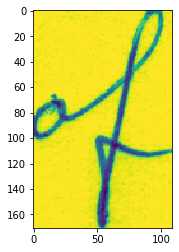

of 




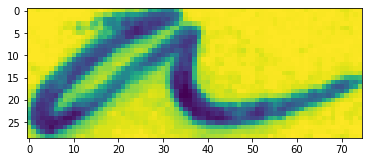

a 




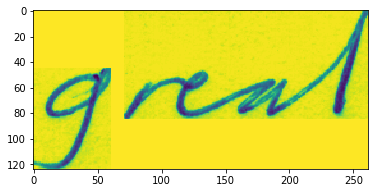

great 




In [33]:
with open('TestInfo.csv') as f:
    csv_reader=csv.reader(f, delimiter=',')
    rows=list(csv_reader)
    count=0
    random.seed(26)
    while count!=3:
        value=random.randint(1, 100)
        line=rows[count]
        #print(line)
        path=line[0]
        #print(path)
        img = mpimg.imread(path)
        imgplot = plt.imshow(img)
        plt.show()
        #print(line)
        label=get_value(label_dict,int(line[1]))
        print(label, '\n\n')
        count+=1
        
f.close()

### Sample pictures after preprocessing

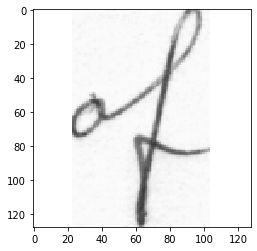

of 




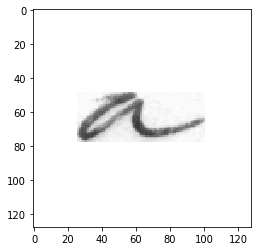

a 




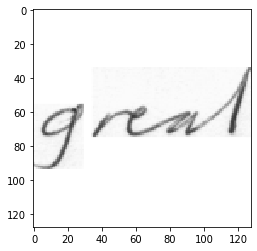

great 




In [32]:
with open('TestInfo.csv') as f:
    csv_reader=csv.reader(f, delimiter=',')
    rows=list(csv_reader)
    count=0
    random.seed(26)
    while count!=3:
        value=random.randint(1, 1000)
        line=rows[count]
        #print(line)
        path=line[0]
        img=preprocess(path, 128, 128)
        #img = mpimg.imread(path)
        #print(img.shape)
        imgplot = plt.imshow(img)
        plt.show()
        label=get_value(label_dict,int(line[1]))
        print(label, '\n\n')
        count+=1
        
f.close()

In [11]:
class MyDataLoader(Dataset):
    
    def __init__(self, ImageInfoFile, transform=None):
        
        self.ImageInfoFile = ImageInfoFile
        self.transform = transform    
        with open(ImageInfoFile) as f:
            self.imagepaths=[line[0] for line in csv.reader(f, delimiter =',')]
        f.close()
        with open(ImageInfoFile) as f:
            self.labels=[line[1] for line in csv.reader(f, delimiter =',')]
        f.close()
        self.labels= list(map(lambda el:int(el), self.labels))
            #print(self.labels)
    
    def __len__(self):
        return len(self.imagepaths)
    

    def __getitem__(self, idx):
        imagepath=self.imagepaths[idx]
        label=self.labels[idx]
        #label=list(label)
        #label=ASCIISentence(label)
        image=preprocess(imagepath, 128, 128)
        plt.imsave('temp.png', image, cmap=cmap)
        image = Image.open(cwd+'\\temp.png')
        image = image.convert('RGB')
        os.remove('temp.png')
        
        #image = np.swapaxes(image, 2, 0)
        #image = np.expand_dims(image, axis=-1)  # Equivalent to x[:,:,np.newaxis]
        #image=Image.open(imagepath)
        #image=preprocess(cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE), (128,32))
        #image = image.convert('RGB')
        
        if self.transform is not None:
            image=self.transform(image)
        return image, label
                

In [12]:
transformations = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
train_set=MyDataLoader(cwd+'\\tempTrain.csv', transform=transformations)
test_set=MyDataLoader(cwd+'\\tempTrain.csv', transform=transformations)

In [14]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size= 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= 32, shuffle=True)

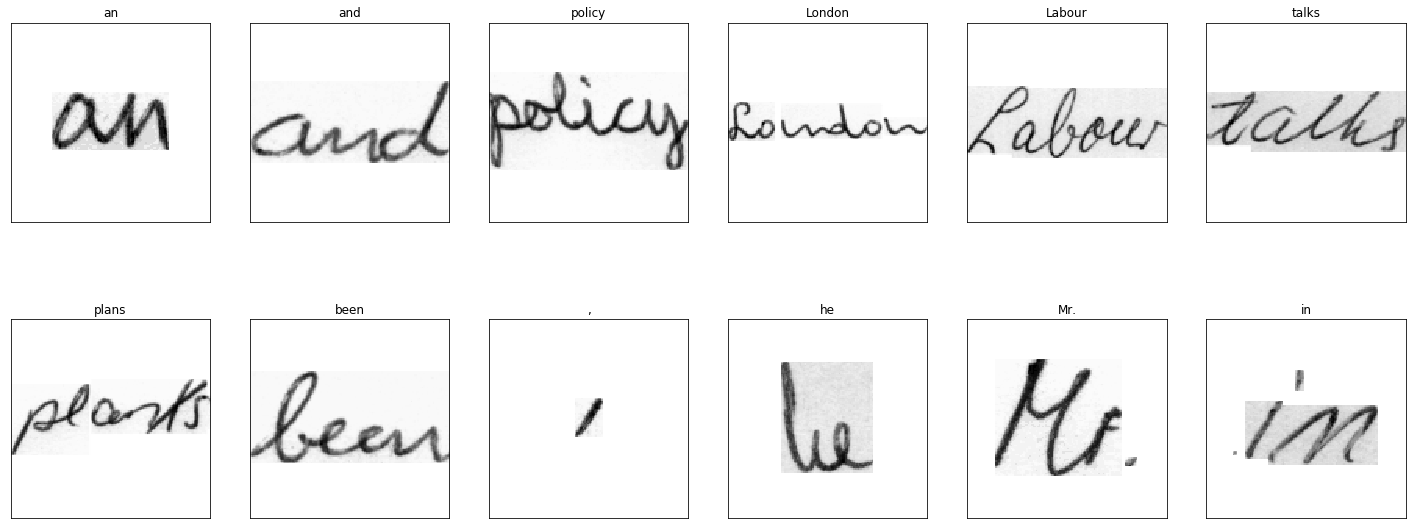

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
# plot the images in the batch, along with the corresponding labels
### print(dataiter.next())
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
plot_size=12
for idx in np.arange(12):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    #images[idx]=np.swapaxes(images[idx], 2, 0)
    ax.imshow(images[idx][0], cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(get_value(label_dict, int(labels[idx])))

In [16]:
images.shape

torch.Size([32, 3, 128, 128])

In [17]:
labels.shape

torch.Size([32])

### Train Network

In [18]:
def moveTo(obj, device):
    '''
    Function moved the obj to the availble device--> either cpu or cuda
    obj: object
    device: cpu or gpu
    '''
    if isinstance(obj, tuple):
        return tuple([moveTo(x, device) for x in obj])
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return x

In [19]:
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=10, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)
            
            batch_size = labels.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0:
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0:
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

In [20]:
### Flatten class referenced from lectures notes
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [21]:
# Loss Function
loss_func=nn.CrossEntropyLoss()

In [22]:
# device to be chosen
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [23]:
device='cpu'

In [24]:
with open('tempTrain.csv') as f:
    labels_xyz=[]
    for line in f:
        labels_xyz.append(line.strip().split(',')[-1])
len(set(labels_xyz))

212

In [25]:
#Dimension of images--> 128 * 128 
D = 128*128  
#Number of channels in the input-->3
C = 3
#Number of classes in the input-->100
classes = len(set(labels_xyz))

#A simple convolutional network:
model_simple_cnn = nn.Sequential(
  #Conv2d follows the pattern of:
  #Conv2d(# of input channels, #filters/output-channels, #filter-size)
  #For the manditory arguments. 
  nn.Conv2d(C, 32, (3, 3), padding=1), 
  #We have to tell pyTorch exactly how many pixels to pad by. 
  #To get 'same' style padding, we want padding=floor(filter-size/2)
  nn.Tanh(),
  Flatten(), #Convert from (B, C, H, W) ->(B, D). This way we can use a Linear layer after
  nn.Linear(32*D, classes),
)

In [26]:
simple_cnn_results = train_network(model_simple_cnn, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device='cpu', epochs=10)

IndexError: Target 12265 is out of bounds.